In [1]:
!pip install wandb
!pip install yfinance

In [2]:
pip install --upgrade ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6beca9ef535b5e0f84b83ec9f771d609a05bcf2562681b96190f499475857b75
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = DEBUG, 1 = INFO, 2 = WARNING, 3 = ERROR

In [4]:
# Bloc 1 : Import des librairies et configuration
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import datetime
import yfinance as yf
import tensorflow as tf
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pickle
import ta

# Configuration initiale de WandB
print("Initializing WandB...")
wandb.login()
wandb.ensure_configured()



Initializing WandB...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# Bloc 2 : Initialisation de WandB
def init_wandb_tracking(stock_symbol='BTC-USD'):
    try:
        # D√©finition des features de base
        base_features = ['Open', 'High', 'Low', 'Close', 'Volume']

        # Configuration des indicateurs techniques
        technical_config = {
            "moving_averages": {
                "enabled": True,
                "periods": [5, 10, 20],
                "features": ['MA_5', 'MA_10', 'MA_20', 'MA_5_pct', 'MA_10_pct', 'MA_20_pct']
            },
            "ema": {
                "enabled": True,
                "periods": [5, 10, 20],
                "features": ['EMA_5', 'EMA_10', 'EMA_20']
            },
            "rsi": {
                "enabled": True,
                "period": 21,
                "features": ['RSI']
            },
            "bollinger_bands": {
                "enabled": True,
                "period": 20,
                "features": ['BB_upper', 'BB_lower', 'BB_width']
            },
            "macd": {
                "enabled": False,
                "params": {"fast": 12, "slow": 26, "signal": 9},
                "features": ['MACD', 'MACD_signal', 'MACD_hist']
            },
            "stochastic": {
                "enabled": True,
                "period": 14,
                "features": ['Stoch_K', 'Stoch_D']
            },
            "momentum": {
                "enabled": True,
                "period": 10,
                "features": ['Momentum', 'ROC']
            },
            "volume": {
                "enabled": True,
                "ma_period": 20,
                "features": ['Volume_MA', 'Volume_ROC', 'OBV']
            },
            "atr": {
                "enabled": True,
                "period": 14,
                "features": ['ATR_14']
            },
            "adx": {
                "enabled": True,
                "period": 14,
                "features": ['ADX_14']
            },
            "ichimoku": {
                "enabled": True,
                "features": ['Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Conversion', 'Ichimoku_Base']
            },
            "vwap": {
                "enabled": True,
                "features": ['VWAP']
            },
            "cmf": {  # Nouvel indicateur
                "enabled": True,
                "period": 20,
                "features": ['CMF_20']
            },
            "cci": {  # Nouvel indicateur
                "enabled": True,
                "period": 20,
                "features": ['CCI_20']
            },
            "trix": {  # Nouvel indicateur
                "enabled": True,
                "period": 15,
                "features": ['Trix_15']
            },
            "williams_r": {  # Nouvel indicateur
                "enabled": True,
                "period": 14,
                "features": ['WilliamsR_14']
            }
        }

        # Construction des features actives
        active_features = base_features.copy()
        for indicator, cfg in technical_config.items():
            if cfg["enabled"]:
                active_features.extend(cfg["features"])

        # Initialisation de WandB
        run = wandb.init(
            project="crypto_lstm",
            name=f"lstm_{stock_symbol}_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}",
            tags=[stock_symbol, "short_term", "Deep Learning", "LSTM", "Optimized"],
            settings=wandb.Settings(init_timeout=120),
            mode="disabled",  # D√©finir sur "online" pour permettre les sweeps
            config={
                "data": {
                    "window_size": 90,
                    "future_prediction_days": 30,
                    "train_test_split": 0.7,
                    "features": active_features,
                    "stock_symbol": stock_symbol,
                    "seed": 42,
                    "scaling_min": 0,
                    "scaling_max": 1,
                    "dataset_info": {},
                },
                "technical_features": technical_config,
                "training": {
                    "optimizer": "sgd",
                    "batch_size": 128,
                    "epochs": 100,
                    "learning_rate": 0.00995,
                    "dropout_rate": 0.23976834504739084,
                    "early_stopping": True,
                    "early_stopping_patience": 15,
                    "validation_split": 0.3,
                    "num_layers": 3,
                    "units_per_layer": [512, 256],
                    "recurrent_dropout": 0.3317792678391172,
                    "momentum": 0.7773944766306407,
                    "intermediate_dense_units": 128,
                    "optimizer_params": {
                        "rmsprop": {
                            "rho": 0.9,
                            "epsilon": 1e-07
                        },
                        "adam": {
                            "epsilon": 1e-07
                        }
                    },
                },
                "model": {
                    "architecture": "lstm_double",
                    "batch_normalization": False,
                    "activation": "tanh",
                    "input_shape": None,  # Sera mis √† jour pendant l'ex√©cution
                    "output_shape": 1,    # Pour la pr√©diction univari√©e
                    "save_format": "keras"
                },
                "metrics": {
                    "loss": "huber",
                    "val_loss": "mse",
                    "mae": True,
                    "rmse": True,
                    "r2_score": True,
                    "mape": True,
                    "mase": True,
                    "directional_accuracy": True,
                    "training_history": {  # Ajout√© pour suivre l'historique
                        "loss": None,
                        "val_loss": None,
                        "final_epoch": None,
                        "learning_rate": None
                    }
                },
                "callbacks": {
                    "early_stopping": {
                        "monitor": "val_loss",
                        "patience": 20,
                        "restore_best_weights": True
                    },
                    "reduce_lr_on_plateau": {
                        "monitor": "val_loss",
                        "factor": 0.46687704937797136,
                        "patience": 5,
                        "min_lr": 0.00001
                    },
                    "model_checkpoint": {
                        "save_best_only": True,
                        "monitor": "val_loss",
                        "filepath": None  # Sera d√©fini avec wandb.run.id
                    }
                },
                "artifacts": {  # Nouveau: pour suivre les artefacts g√©n√©r√©s
                    "model_path": None,
                    "scaler_path": "scaler.pkl",
                    "best_model_path": "best_model.keras"
                }
            }
        )
        print(f"WandB run initialized with ID: {run.id}")
        return run
    except Exception as e:
        print(f"Error initializing WandB: {str(e)}")
        return None



In [6]:
# Bloc 3 : Import et pr√©traitement des donn√©es
def import_and_preprocess_data():
    try:
        print("\n" + "="*50)
        print("D√âBUT DE L'IMPORTATION ET PR√âTRAITEMENT DES DONN√âES")
        print("="*50)

        # V√©rification que WandB est initialis√©
        if wandb.run is None:
            raise Exception("WandB n'est pas initialis√©")

        # Initialisation du seed
        print("\n[1] Configuration du seed...")
        np.random.seed(wandb.config.data['seed'])
        print(f"‚úì Seed configur√© √†: {wandb.config.data['seed']}")

        # R√©cup√©ration des donn√©es
        print("\n[2] T√©l√©chargement des donn√©es depuis Yahoo Finance...")
        print(f"Symbole recherch√©: {wandb.config.data['stock_symbol']}")
        data = yf.download(wandb.config.data['stock_symbol'])

        # V√©rification des donn√©es
        if data.empty:
            raise Exception("Aucune donn√©e n'a √©t√© r√©cup√©r√©e")

        print("\n[3] Analyse des donn√©es:")
        print(f"‚úì Nombre d'enregistrements: {len(data):,}")
        print(f"‚úì P√©riode: {data.index.min().strftime('%Y-%m-%d')} au {data.index.max().strftime('%Y-%m-%d')}")

        # Gestion du MultiIndex
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [f"{col[0]}" for col in data.columns]

        # V√©rification des valeurs manquantes
        missing_values = data.isnull().sum()
        if missing_values.any():
            print("\n[4] Traitement des valeurs manquantes")
            data.fillna(method='ffill', inplace=True)
            print("‚úì Valeurs manquantes combl√©es")

        # Log WandB minimal
        wandb.log({
            "data_import": {
                "dataset_size": len(data),
                "missing_values": bool(missing_values.any()),
                "date_range": {
                    "start": data.index.min().strftime('%Y-%m-%d'),
                    "end": data.index.max().strftime('%Y-%m-%d')
                }
            }
        })

        print("\n" + "="*50)
        print("FIN DE L'IMPORTATION ET PR√âTRAITEMENT DES DONN√âES")
        print("="*50)

        return data

    except Exception as e:
        print(f"\n‚ùå ERREUR: {str(e)}")
        wandb.log({"data_import_error": str(e)})
        raise

# S√©quence d'ex√©cution
try:
    # 1. Initialisation de WandB
    run = init_wandb_tracking()
    if run is None:
        raise Exception("√âchec de l'initialisation de WandB")

    # 2. Import et pr√©traitement des donn√©es
    data = import_and_preprocess_data()

    print("\nInitialisation compl√®te!")

except Exception as e:
    print(f"\n‚ùå ERREUR FATALE: {str(e)}")
    if wandb.run is not None:
        wandb.finish()

WandB run initialized with ID: et6e892e

D√âBUT DE L'IMPORTATION ET PR√âTRAITEMENT DES DONN√âES

[1] Configuration du seed...
‚úì Seed configur√© √†: 42

[2] T√©l√©chargement des donn√©es depuis Yahoo Finance...
Symbole recherch√©: BTC-USD


[*********************100%***********************]  1 of 1 completed


[3] Analyse des donn√©es:
‚úì Nombre d'enregistrements: 3,768
‚úì P√©riode: 2014-09-17 au 2025-01-09

FIN DE L'IMPORTATION ET PR√âTRAITEMENT DES DONN√âES

Initialisation compl√®te!


In [7]:
# Bloc 4 : Ajout des indicateurs techniques
def add_technical_indicators(df, config):
    print("\n" + "="*50)
    print("D√âBUT DE L'AJOUT DES INDICATEURS TECHNIQUES")
    print("="*50)

    original_length = len(df)
    initial_features = set(df.columns)
    tech_features = config['technical_features']  # Acc√®s correct aux cl√©s

    print(f"\nDonn√©es initiales:")
    print(f"‚úì Nombre d'enregistrements: {original_length:,}")
    print(f"‚úì Features initiales: {', '.join(initial_features)}")

    # Compteur pour les indicateurs ajout√©s
    indicators_added = []

    # 1. Moyennes Mobiles (Moving Averages)
    if tech_features['moving_averages']['enabled']:
        print("\n[1] Ajout des Moyennes Mobiles")
        for period in tech_features['moving_averages']['periods']:
            df[f'MA_{period}'] = df['Close'].rolling(window=period).mean()
            df[f'MA_{period}_pct'] = df['Close'].pct_change(periods=period)
            indicators_added.extend([f'MA_{period}', f'MA_{period}_pct'])
        print(f"‚úì P√©riodes utilis√©es: {tech_features['moving_averages']['periods']}")

    # 2. Moyennes Mobiles Exponentielles (EMA)
    if tech_features.get('ema', {}).get('enabled', False):
        print("\n[2] Ajout des Moyennes Mobiles Exponentielles (EMA)")
        for period in tech_features['ema']['periods']:
            df[f'EMA_{period}'] = df['Close'].ewm(span=period, adjust=False).mean()
            indicators_added.append(f'EMA_{period}')
        print(f"‚úì P√©riodes EMA: {tech_features['ema']['periods']}")

    # 3. RSI (Relative Strength Index)
    if tech_features['rsi']['enabled']:
        print("\n[3] Calcul du RSI")
        period = tech_features['rsi']['period']
        rsi = ta.momentum.RSIIndicator(close=df['Close'], window=period)
        df['RSI'] = rsi.rsi()
        indicators_added.append('RSI')
        print(f"‚úì P√©riode RSI: {period}")

    # 4. Bandes de Bollinger (Bollinger Bands)
    if tech_features['bollinger_bands']['enabled']:
        print("\n[4] Calcul des Bandes de Bollinger")
        period = tech_features['bollinger_bands']['period']
        bollinger = ta.volatility.BollingerBands(close=df['Close'], window=period, window_dev=2)
        df['BB_upper'] = bollinger.bollinger_hband()
        df['BB_lower'] = bollinger.bollinger_lband()
        df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['Close']
        indicators_added.extend(['BB_upper', 'BB_lower', 'BB_width'])
        print(f"‚úì P√©riode Bollinger: {period}")

    # 5. MACD (Moving Average Convergence Divergence)
    if tech_features['macd']['enabled']:
        print("\n[5] Calcul du MACD")
        fast = tech_features['macd']['params']['fast']
        slow = tech_features['macd']['params']['slow']
        signal = tech_features['macd']['params']['signal']
        macd = ta.trend.MACD(close=df['Close'], window_slow=slow, window_fast=fast, window_sign=signal)
        df['MACD'] = macd.macd()
        df['MACD_signal'] = macd.macd_signal()
        df['MACD_hist'] = macd.macd_diff()
        indicators_added.extend(['MACD', 'MACD_signal', 'MACD_hist'])
        print(f"‚úì Param√®tres MACD: fast={fast}, slow={slow}, signal={signal}")

    # 6. Oscillateur Stochastique (Stochastic Oscillator)
    if tech_features['stochastic']['enabled']:
        print("\n[6] Calcul du Stochastique")
        period = tech_features['stochastic']['period']
        stochastic = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=period, smooth_window=3)
        df['Stoch_K'] = stochastic.stoch()
        df['Stoch_D'] = stochastic.stoch_signal()
        indicators_added.extend(['Stoch_K', 'Stoch_D'])
        print(f"‚úì P√©riode Stochastique: {period}")

    # 7. Momentum et ROC (Rate of Change)
    if tech_features['momentum']['enabled']:
        print("\n[7] Calcul du Momentum et ROC")
        period = tech_features['momentum']['period']
        try:
            # Utiliser le param√®tre correct 'lbp'
            williams_r = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=period)
            df['WilliamsR_14'] = williams_r.williams_r()
            indicators_added.append('WilliamsR_14')
            print(f"‚úì P√©riode Williams %R: {period}")
        except TypeError as te:
            print(f"‚ùå Erreur lors du calcul de Williams %R: {str(te)}")
            indicators_added.append('WilliamsR_Error')
            # Optionnel : Vous pouvez d√©cider de lever l'exception ou de continuer
            raise

        try:
            # Tente d'utiliser MomentumIndicator
            df['Momentum'] = ta.momentum.MomentumIndicator(close=df['Close'], window=period).momentum()
            indicators_added.append('Momentum')
            print(f"‚úì P√©riode Momentum: {period}")
        except AttributeError:
            print("‚ö† MomentumIndicator n'est pas disponible. Utilisation de ROCIndicator comme alternative.")
            # Utilisation de ROCIndicator pour Momentum
            try:
                df['Momentum'] = ta.momentum.ROCIndicator(close=df['Close'], window=period).roc()
                indicators_added.append('Momentum (ROC)')
                print(f"‚úì P√©riode ROC utilis√©e pour Momentum: {period}")
            except AttributeError:
                print("‚ö† ROCIndicator n'est pas disponible. Calcul manuel du Momentum.")
                df['Momentum'] = df['Close'] - df['Close'].shift(period)
                indicators_added.append('Momentum (manual)')
                print(f"‚úì P√©riode Momentum (manuel): {period}")

        # Calcul du ROC
        try:
            df['ROC'] = ta.momentum.ROCIndicator(close=df['Close'], window=period).roc()
            indicators_added.append('ROC')
            print(f"‚úì P√©riode ROC: {period}")
        except AttributeError:
            print("‚ö† ROCIndicator n'est pas disponible. Calcul manuel du ROC.")
            df['ROC'] = ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period)) * 100
            indicators_added.append('ROC (manual)')
            print(f"‚úì P√©riode ROC (manuel): {period}")

    # 8. Indicateurs de Volume
    if tech_features['volume']['enabled']:
        print("\n[8] Calcul des Indicateurs de Volume")
        ma_period = tech_features['volume']['ma_period']
        df['Volume_MA'] = df['Volume'].rolling(window=ma_period).mean()
        df['Volume_ROC'] = df['Volume'].pct_change()
        obv = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'])
        df['OBV'] = obv.on_balance_volume()
        indicators_added.extend(['Volume_MA', 'Volume_ROC', 'OBV'])
        print(f"‚úì P√©riode Volume MA: {ma_period}")

    # 9. Average True Range (ATR)
    if tech_features.get('atr', {}).get('enabled', False):
        print("\n[9] Calcul de l'Average True Range (ATR)")
        period = tech_features['atr']['period']
        atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=period)
        df['ATR_14'] = atr.average_true_range()
        indicators_added.append('ATR_14')
        print(f"‚úì P√©riode ATR: {period}")

    # 10. Average Directional Index (ADX)
    if tech_features.get('adx', {}).get('enabled', False):
        print("\n[10] Calcul de l'Average Directional Index (ADX)")
        period = tech_features['adx']['period']
        adx = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=period)
        df['ADX_14'] = adx.adx()
        indicators_added.append('ADX_14')
        print(f"‚úì P√©riode ADX: {period}")

    # 11. Ichimoku Cloud
    if tech_features.get('ichimoku', {}).get('enabled', False):
        print("\n[11] Calcul de l'Ichimoku Cloud")
        ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
        df['Ichimoku_Conversion'] = ichimoku.ichimoku_conversion_line()
        df['Ichimoku_Base'] = ichimoku.ichimoku_base_line()
        df['Ichimoku_A'] = ichimoku.ichimoku_a()
        df['Ichimoku_B'] = ichimoku.ichimoku_b()
        indicators_added.extend(['Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Conversion', 'Ichimoku_Base'])
        print("‚úì Ichimoku Cloud calcul√© avec succ√®s")

    # 12. Volume Weighted Average Price (VWAP)
    if tech_features.get('vwap', {}).get('enabled', False):
        print("\n[12] Calcul du Volume Weighted Average Price (VWAP)")
        vwap = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=14)
        df['VWAP'] = vwap.volume_weighted_average_price()
        indicators_added.append('VWAP')
        print("‚úì VWAP calcul√© avec succ√®s")

    # 13. Chaikin Money Flow (CMF)
    if tech_features.get('cmf', {}).get('enabled', False):
        print("\n[13] Calcul du Chaikin Money Flow (CMF)")
        period = tech_features['cmf']['period']
        cmf = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=period)
        df['CMF_20'] = cmf.chaikin_money_flow()
        indicators_added.append('CMF_20')
        print(f"‚úì P√©riode CMF: {period}")

    # 14. Commodity Channel Index (CCI)
    if tech_features.get('cci', {}).get('enabled', False):
        print("\n[14] Calcul du Commodity Channel Index (CCI)")
        period = tech_features['cci']['period']
        cci = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=period)
        df['CCI_20'] = cci.cci()
        indicators_added.append('CCI_20')
        print(f"‚úì P√©riode CCI: {period}")

    # 15. Trix (Triple Exponential Average)
    if tech_features.get('trix', {}).get('enabled', False):
        print("\n[15] Calcul du Trix (Triple Exponential Average)")
        period = tech_features['trix']['period']
        trix = ta.trend.TRIXIndicator(close=df['Close'], window=period)
        df['Trix_15'] = trix.trix()
        indicators_added.append('Trix_15')
        print(f"‚úì P√©riode Trix: {period}")

    # 16. Williams %R
    if tech_features.get('williams_r', {}).get('enabled', False):
        print("\n[16] Calcul du Williams %R")
        period = tech_features['williams_r']['period']
        try:
            # Utiliser le param√®tre correct 'lbp'
            williams_r = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=period)
            df['WilliamsR_14'] = williams_r.williams_r()
            indicators_added.append('WilliamsR_14')
            print(f"‚úì P√©riode Williams %R: {period}")
        except TypeError as te:
            print(f"‚ùå Erreur lors du calcul de Williams %R: {str(te)}")
            indicators_added.append('WilliamsR_Error')
            # Optionnel : Vous pouvez d√©cider de lever l'exception ou de continuer
            raise

    # Nettoyage final
    print("\n[17] Nettoyage des donn√©es")
    initial_rows = len(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    rows_removed = initial_rows - len(df)
    print(f"‚úì Lignes supprim√©es: {rows_removed:,} ({(rows_removed/original_length)*100:.2f}%)")

    # R√©sum√© final
    print("\n" + "-"*50)
    print("R√âSUM√â DES MODIFICATIONS:")
    print(f"‚Ä¢ Indicateurs ajout√©s: {len(indicators_added)}")
    print(f"‚Ä¢ Indicateurs sp√©cifiques ajout√©s: {', '.join(indicators_added)}")
    print(f"‚Ä¢ Nombre final de features: {len(df.columns)}")
    print(f"‚Ä¢ R√©tention des donn√©es: {(len(df)/original_length)*100:.2f}%")
    print("-"*50)

    # Logging WandB
    wandb.log({
        "technical_indicators": {
            "active_indicators": {
                "moving_averages": tech_features['moving_averages']['enabled'],
                "ema": tech_features.get('ema', {}).get('enabled', False),
                "rsi": tech_features['rsi']['enabled'],
                "bollinger_bands": tech_features['bollinger_bands']['enabled'],
                "macd": tech_features['macd']['enabled'],
                "stochastic": tech_features['stochastic']['enabled'],
                "momentum": tech_features['momentum']['enabled'],
                "volume": tech_features['volume']['enabled'],
                "atr": tech_features.get('atr', {}).get('enabled', False),
                "adx": tech_features.get('adx', {}).get('enabled', False),
                "ichimoku": tech_features.get('ichimoku', {}).get('enabled', False),
                "vwap": tech_features.get('vwap', {}).get('enabled', False),
                "cmf": tech_features.get('cmf', {}).get('enabled', False),
                "cci": tech_features.get('cci', {}).get('enabled', False),
                "trix": tech_features.get('trix', {}).get('enabled', False),
                "williams_r": tech_features.get('williams_r', {}).get('enabled', False)
            },
            "feature_count": len(indicators_added),
            "data_retention": f"{(len(df)/original_length)*100:.2f}%",
        }
    })

    print("\n" + "="*50)
    print("FIN DE L'AJOUT DES INDICATEURS TECHNIQUES")
    print("="*50)

    return df


In [8]:
#Bloc 5 : Preprocessing

def preprocess_data(data, config):
    """
    Pr√©traite les donn√©es et ajoute les indicateurs techniques
    """
    print("\n" + "="*50)
    print("D√âBUT DU PR√âTRAITEMENT DES DONN√âES")
    print("="*50)

    initial_shape = data.shape
    print(f"\n[1] Forme initiale des donn√©es: {initial_shape[0]:,} lignes √ó {initial_shape[1]} colonnes")

    # Pr√©traitement de base
    print("\n[2] Tri et formatage des donn√©es")
    data = data.sort_index(ascending=True)
    print("‚úì Donn√©es tri√©es par ordre chronologique")

    # Gestion du MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        print("\n[3] D√©tection d'un MultiIndex - Aplatissement des colonnes")
        print("Colonnes avant aplatissement:", data.columns.tolist())
        data.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in data.columns]
        print("‚úì Nouvelles colonnes:", data.columns.tolist())
    else:
        print("\n[3] Format des colonnes standard - Pas d'aplatissement n√©cessaire")

    # Gestion des dates
    print("\n[4] Formatage de l'index temporel")
    data.reset_index(inplace=True)
    data.rename(columns={'Date': 'date'}, inplace=True)
    data['date'] = pd.to_datetime(data['date'])
    print(f"‚úì Plage temporelle: {data['date'].min().strftime('%Y-%m-%d')} au {data['date'].max().strftime('%Y-%m-%d')}")

    # Renommage des colonnes
    if any('AF.PA' in col for col in data.columns):
        print("\n[5] D√©tection du suffixe AF.PA - Renommage des colonnes")
        rename_dict = {
            'Adj Close_AF.PA': 'Adj Close',
            'Close_AF.PA': 'Close',
            'High_AF.PA': 'High',
            'Low_AF.PA': 'Low',
            'Open_AF.PA': 'Open',
            'Volume_AF.PA': 'Volume'
        }
        data.rename(columns=rename_dict, inplace=True)
        print("‚úì Colonnes renomm√©es:", list(rename_dict.values()))

    # Gestion des valeurs manquantes
    print("\n[6] Analyse des valeurs manquantes")
    missing_values = data.isnull().sum()
    has_missing = missing_values.any()

    if has_missing:
        missing_count = missing_values.sum()
        missing_pct = (missing_count / (data.shape[0] * data.shape[1])) * 100
        print(f"‚ö† D√©tection de {missing_count:,} valeurs manquantes ({missing_pct:.2f}%)")

        # D√©tail par colonne
        for col, count in missing_values[missing_values > 0].items():
            print(f"  - {col}: {count:,} valeurs manquantes")

        print("Application de la m√©thode forward fill...")
        data.fillna(method="ffill", inplace=True)
        print("‚úì Valeurs manquantes combl√©es")

        wandb.log({
            "data_quality": {
                "missing_values_percentage": missing_pct
            }
        })
    else:
        print("‚úì Aucune valeur manquante d√©tect√©e")

    # Ajout des indicateurs techniques
    print("\n[7] Ajout des indicateurs techniques")
    try:
        data = add_technical_indicators(data, config)
        print(f"‚úì {len(data.columns) - 1} features apr√®s ajout des indicateurs")  # -1 pour la colonne date

        config.data['dataset_info'].update({
            "features_count": len(data.columns) - 1
        })

    except Exception as e:
        print(f"‚ùå Erreur lors de l'ajout des indicateurs: {str(e)}")
        wandb.log({
            "preprocessing_status": "failed",
            "error_type": str(type(e).__name__)
        })
        raise

    # S√©lection des features
    print("\n[8] S√©lection des features finales")
    base_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    technical_features = [col for col in data.columns if col not in ['date'] + base_features]

    print(f"Features de base: {', '.join(base_features)}")
    print(f"Features techniques: {len(technical_features)} indicateurs ajout√©s")

    # S√©lection finale
    data_features = data[config.data['features']]

    # R√©sum√© final
    print("\n" + "-"*50)
    print("R√âSUM√â DU PR√âTRAITEMENT:")
    print(f"‚Ä¢ Dimensions initiales: {initial_shape[0]:,} √ó {initial_shape[1]}")
    print(f"‚Ä¢ Dimensions finales: {data_features.shape[0]:,} √ó {data_features.shape[1]}")
    print(f"‚Ä¢ R√©tention des donn√©es: {(data_features.shape[0]/initial_shape[0])*100:.2f}%")
    print(f"‚Ä¢ Nombre total de features: {len(data_features.columns)}")
    print("-"*50)

    # Logging final
    wandb.log({
        "preprocessing_summary": {
            "input_dimensions": f"{initial_shape[0]}x{initial_shape[1]}",
            "output_dimensions": f"{data_features.shape[0]}x{data_features.shape[1]}",
            "data_retention": f"{(data_features.shape[0]/initial_shape[0])*100:.2f}%"
        }
    })

    print("\n" + "="*50)
    print("FIN DU PR√âTRAITEMENT DES DONN√âES")
    print("="*50)

    return data, data_features

In [9]:
#Bloc 6 : Preparation des sequences

def prepare_sequences(data, config):
   print("\n" + "="*80)
   print("D√âBUT DE LA PR√âPARATION DES S√âQUENCES".center(80))
   print("="*80 + "\n")

   print(f"[1] V√âRIFICATION DE LA STRUCTURE DES DONN√âES")
   print(f"{'‚Ä¢':<3}Shape initial: {data.shape}")

   # Gestion du MultiIndex et renommage
   if isinstance(data.columns, pd.MultiIndex):
       print(f"\n[2] D√âTECTION D'UN MULTIINDEX")
       print(f"{'‚Ä¢':<3}Colonnes avant:")
       for col in data.columns.tolist():
           print(f"{'':>6}- {col}")
       data.columns = [f"{col[0]}" for col in data.columns]
       print(f"\n{'‚Ä¢':<3}Colonnes apr√®s:")
       for col in data.columns.tolist():
           print(f"{'':>6}- {col}")
   elif any('AC.PA' in col for col in data.columns):
       print("\n[2] RENOMMAGE DES COLONNES AC.PA")
       rename_dict = {
           'Adj Close_AC.PA': 'Adj Close',
           'Close_AC.PA': 'Close',
           'High_AC.PA': 'High',
           'Low_AC.PA': 'Low',
           'Open_AC.PA': 'Open',
           'Volume_AC.PA': 'Volume'
       }
       data = data.rename(columns=rename_dict)
       print("‚úì Colonnes renomm√©es avec succ√®s")

   # V√©rification des colonnes requises
   print("\n[3] V√âRIFICATION DES COLONNES REQUISES")
   required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
   missing_columns = [col for col in required_columns if col not in data.columns]
   if missing_columns:
       print("‚ùå ERREUR: Colonnes manquantes d√©tect√©es")
       for col in missing_columns:
           print(f"{'':>3}- {col}")
       raise ValueError(f"Colonnes manquantes apr√®s renommage: {missing_columns}")
   print("‚úì Toutes les colonnes requises sont pr√©sentes")

   print("\n[4] PR√âTRAITEMENT DES DONN√âES")
   data, data_features = preprocess_data(data, config)
   print(f"‚úì Shape apr√®s pr√©traitement: {data_features.shape}")

   # V√©rification des features disponibles
   print("\n[5] V√âRIFICATION DES FEATURES")
   available_features = [col for col in config.data['features'] if col in data_features.columns]
   if not available_features:
       print("‚ùå ERREUR: Aucune feature disponible")
       raise ValueError("Aucune feature demand√©e n'est disponible dans les donn√©es")

   # Features manquantes
   missing_features = set(config.data['features']) - set(available_features)
   if missing_features:
       print("\n‚ö† Features manquantes d√©tect√©es:")
       for feature in sorted(missing_features):
           print(f"{'':>3}- {feature}")
       wandb.log({
           "features_warning": {
               "missing_features": list(missing_features),
               "available_features": available_features
           }
       })
   print(f"\n‚úì {len(available_features)} features disponibles")
   print(f"{'‚Ä¢':<3}Features pr√©sentes:")
   for feat in sorted(available_features):
       print(f"{'':>6}- {feat}")

   # Utilisation des features disponibles
   data_features = data_features[available_features]

   print("\n[6] NORMALISATION DES DONN√âES")
   scaler = MinMaxScaler(feature_range=(
       config.data.get("scaling_min", 0),
       config.data.get("scaling_max", 1)
   ))
   scaled_data = scaler.fit_transform(data_features)

   print("\nAnalyse des valeurs avant normalisation:")
   print(f"{'‚Ä¢':<3}Minimum global: {data_features.min().min():.2f}")
   print(f"{'‚Ä¢':<3}Maximum global: {data_features.max().max():.2f}")
   print(f"\n‚úì Donn√©es normalis√©es avec succ√®s")
   print(f"{'‚Ä¢':<3}Plage de normalisation: [{config.data.get('scaling_min', 0)}, {config.data.get('scaling_max', 1)}]")

   print("\n[7] CR√âATION DES S√âQUENCES")
   window_size = config.data['window_size']
   target_column_name = "Close"
   target_column = list(data_features.columns).index(target_column_name)
   print(f"{'‚Ä¢':<3}Configuration:")
   print(f"{'':>6}- Taille de fen√™tre: {window_size}")
   print(f"{'':>6}- Colonne cible: {target_column_name} (index: {target_column})")

   X, Y = [], []
   for i in range(window_size, len(scaled_data)):
       X.append(scaled_data[i - window_size:i])
       Y.append(scaled_data[i, target_column])

   X, Y = np.array(X), np.array(Y)
   print(f"\n‚úì S√©quences cr√©√©es avec succ√®s")
   print(f"{'‚Ä¢':<3}Dimensions:")
   print(f"{'':>6}- X: {X.shape}")
   print(f"{'':>6}- Y: {Y.shape}")

   if len(X) == 0 or len(Y) == 0:
       print("\n‚ùå ERREUR: S√©quences vides g√©n√©r√©es")
       raise ValueError("Les s√©quences d'entra√Ænement sont vides")

   print("\n[8] DIVISION TRAIN/TEST")
   training_size = int(len(X) * config.data['train_test_split'])
   X_train, X_test = X[:training_size], X[training_size:]
   Y_train, Y_test = Y[:training_size], Y[training_size:]

   print(f"{'‚Ä¢':<3}Configuration:")
   print(f"{'':>6}- Ratio train/test: {config.data['train_test_split']}")
   print(f"\n{'‚Ä¢':<3}Dimensions des ensembles:")
   print(f"{'':>6}- Train - X: {X_train.shape}, Y: {Y_train.shape}")
   print(f"{'':>6}- Test  - X: {X_test.shape}, Y: {Y_test.shape}")

   print("\n[9] SAUVEGARDE DU MOD√àLE DE NORMALISATION")
   scaler_filename = "scaler.pkl"
   with open(scaler_filename, "wb") as f:
       pickle.dump(scaler, f)
   print(f"‚úì Scaler sauvegard√©: {scaler_filename}")

   # Log de l'artefact scaler
   scaler_artifact = wandb.Artifact(
       name=f"data_scaler_{wandb.run.id}",
       type="scaler",
       description="MinMaxScaler pour la normalisation"
   )
   scaler_artifact.add_file(scaler_filename)
   wandb.log_artifact(scaler_artifact)

   # R√©sum√© final
   print("\n" + "="*80)
   print("R√âSUM√â DE LA PR√âPARATION DES DONN√âES".center(80))
   print("-"*80)
   print(f"{'M√âTRIQUES G√âN√âRALES':^40}{'DIMENSIONS DES DONN√âES':^40}")
   print("-"*80)
   print(f"{'‚Ä¢':<3}Nombre de features:{len(available_features):>18}")
   print(f"{'‚Ä¢':<3}S√©quences totales:{len(X):>19}")
   print(f"{'‚Ä¢':<3}S√©quences d'entra√Ænement:{len(X_train):>12}")
   print(f"{'‚Ä¢':<3}S√©quences de test:{len(X_test):>19}")
   print(f"{'‚Ä¢':<3}Taille des s√©quences:{window_size:>16}")
   print(f"{'‚Ä¢':<3}R√©tention des donn√©es:{(len(X)/len(data)*100):>15.2f}%")
   print("="*80)

   # Log WandB
   wandb.log({
       "data_preparation": {
           "dataset_split": {
               "training_size": len(X_train),
               "test_size": len(X_test),
               "sequence_length": window_size
           },
           "data_dimensions": {
               "features": len(data_features.columns),
               "total_sequences": len(X)
           },
           "data_retention": f"{(len(X)/len(data)*100):.2f}%"
       }
   })

   print("\n" + "="*80)
   print("‚úì PR√âPARATION DES S√âQUENCES TERMIN√âE AVEC SUCC√àS".center(80))
   print("="*80 + "\n")

   return X_train, X_test, Y_train, Y_test, scaler

X_train, X_test, Y_train, Y_test, scaler = prepare_sequences(data, wandb.config)


                     D√âBUT DE LA PR√âPARATION DES S√âQUENCES                      

[1] V√âRIFICATION DE LA STRUCTURE DES DONN√âES
‚Ä¢  Shape initial: (3768, 5)

[3] V√âRIFICATION DES COLONNES REQUISES
‚úì Toutes les colonnes requises sont pr√©sentes

[4] PR√âTRAITEMENT DES DONN√âES

D√âBUT DU PR√âTRAITEMENT DES DONN√âES

[1] Forme initiale des donn√©es: 3,768 lignes √ó 5 colonnes

[2] Tri et formatage des donn√©es
‚úì Donn√©es tri√©es par ordre chronologique

[3] Format des colonnes standard - Pas d'aplatissement n√©cessaire

[4] Formatage de l'index temporel
‚úì Plage temporelle: 2014-09-17 au 2025-01-09

[6] Analyse des valeurs manquantes
‚úì Aucune valeur manquante d√©tect√©e

[7] Ajout des indicateurs techniques

D√âBUT DE L'AJOUT DES INDICATEURS TECHNIQUES

Donn√©es initiales:
‚úì Nombre d'enregistrements: 3,768
‚úì Features initiales: Open, Low, date, High, Close, Volume

[1] Ajout des Moyennes Mobiles
‚úì P√©riodes utilis√©es: [5, 10, 20]

[2] Ajout des Moyennes Mobiles Expon

In [10]:
# Bloc 7 : Entrainement du modele LSTM

# Imports n√©cessaires
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

def train_lstm_model(X_train, X_test, Y_train, Y_test, config):
    print("\nConfiguration WandB actuelle:")
    print(config)  # Ajoutez ceci pour v√©rifier la configuration

    print("\n" + "="*80)
    print("D√âBUT DE L'ENTRA√éNEMENT DU MOD√àLE LSTM".center(80))
    print("="*80)

    # Construction du mod√®le
    print("\n[1] Configuration du mod√®le")
    model = Sequential()

    # Mise √† jour de input_shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    print(f"‚Ä¢ Shape d'entr√©e: {input_shape}")

    # Cr√©ation d'une couche d'entr√©e explicite
    model.add(tf.keras.Input(shape=input_shape))

    # Premi√®re couche LSTM
    model.add(LSTM(
        units=config['training']['units_per_layer'][0],
        return_sequences=True,
        dropout=config['training']['dropout_rate'],
        recurrent_dropout=config['training']['recurrent_dropout']
    ))
    if config['model']['batch_normalization']:
        model.add(BatchNormalization())

    # Deuxi√®me couche LSTM
    model.add(LSTM(
        units=config['training']['units_per_layer'][1],
        return_sequences=False,
        dropout=config['training']['dropout_rate'],
        recurrent_dropout=config['training']['recurrent_dropout']
    ))
    if config['model']['batch_normalization']:
        model.add(BatchNormalization())

    # Couche Dense interm√©diaire
    model.add(Dense(
        units=config['training']['intermediate_dense_units'],
        activation=config['model']['activation']
    ))
    model.add(Dropout(config['training']['dropout_rate']))

    # Couche de sortie
    model.add(Dense(units=config['model']['output_shape']))

    print("\n[2] Configuration de l'optimisation")
    # Map des optimiseurs
    optimizers = {
        'rmsprop': tf.keras.optimizers.RMSprop(
            learning_rate=config['training']['learning_rate'],
            momentum=config['training']['momentum']
        ),
        'adam': tf.keras.optimizers.Adam(
            learning_rate=config['training']['learning_rate']
        ),
        'sgd': tf.keras.optimizers.SGD(
            learning_rate=config['training']['learning_rate'],
            momentum=config['training']['momentum']
        )
    }

    optimizer = optimizers[config['training']['optimizer']]
    print(f"‚Ä¢ Optimiseur: {config['training']['optimizer']}")
    print(f"‚Ä¢ Learning rate: {config['training']['learning_rate']}")

    model.compile(optimizer=optimizer, loss=config['metrics']['loss'])

    print("\n[3] Configuration des callbacks")
    callbacks = [
        EarlyStopping(
            monitor=config['callbacks']['early_stopping']['monitor'],
            patience=config['callbacks']['early_stopping']['patience'],
            restore_best_weights=config['callbacks']['early_stopping']['restore_best_weights']
        ),
        ReduceLROnPlateau(
            monitor=config['callbacks']['reduce_lr_on_plateau']['monitor'],
            factor=config['callbacks']['reduce_lr_on_plateau']['factor'],
            patience=config['callbacks']['reduce_lr_on_plateau']['patience'],
            min_lr=config['callbacks']['reduce_lr_on_plateau']['min_lr']
        ),
        ModelCheckpoint(
            config['callbacks']['model_checkpoint']['filepath'] or 'best_model.keras',
            monitor=config['callbacks']['model_checkpoint']['monitor'],
            save_best_only=config['callbacks']['model_checkpoint']['save_best_only']
        )
    ]
    print("‚Ä¢ Early Stopping configur√©")
    print("‚Ä¢ ReduceLROnPlateau configur√©")
    print("‚Ä¢ ModelCheckpoint configur√©")

    print("\n[4] Entra√Ænement du mod√®le")
    start_time = time.time()
    history = model.fit(
        X_train, Y_train,
        epochs=config['training']['epochs'],
        batch_size=config['training']['batch_size'],
        validation_data=(X_test, Y_test),
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time

    print("\n[5] √âvaluation du mod√®le")
    predicted_test = model.predict(X_test, verbose=0)

    # Calcul des m√©triques principales
    mae = mean_absolute_error(Y_test, predicted_test)
    mse = mean_squared_error(Y_test, predicted_test)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, predicted_test) * 100
    r2 = r2_score(Y_test, predicted_test)

    # Calcul de la pr√©cision directionnelle
    def calculate_directional_accuracy(y_true, y_pred):
        true_diff = np.diff(y_true.reshape(-1))
        pred_diff = np.diff(y_pred.reshape(-1))
        return np.mean((true_diff * pred_diff) > 0) * 100

    dir_acc = calculate_directional_accuracy(Y_test, predicted_test)

    # Log WandB optimis√©
    wandb.log({
        "model_performance": {
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "mape": mape,
            "r2": r2,
            "directional_accuracy": dir_acc
        },
        "training_info": {
            "final_epoch": len(history.history['loss']),
            "best_val_loss": min(history.history['val_loss']),
            "training_time_minutes": training_time / 60
        }
    })

    # R√©sum√© final
    print("\n" + "="*80)
    print("R√âSUM√â DE L'ENTRA√éNEMENT".center(80))
    print("-"*80)
    print(f"‚Ä¢ MAE: {mae:.4f}")
    print(f"‚Ä¢ MSE: {mse:.4f}")
    print(f"‚Ä¢ RMSE: {rmse:.4f}")
    print(f"‚Ä¢ MAPE: {mape:.2f}%")
    print(f"‚Ä¢ R¬≤: {r2:.4f}")
    print(f"‚Ä¢ Pr√©cision directionnelle: {dir_acc:.2f}%")
    print(f"‚Ä¢ Meilleure perte de validation: {min(history.history['val_loss']):.4f}")
    print(f"‚Ä¢ Temps d'entra√Ænement: {training_time/60:.2f} minutes")
    print("="*80)

    return model, history

# Appel de la fonction
model, history = train_lstm_model(X_train, X_test, Y_train, Y_test, wandb.config)



Configuration WandB actuelle:
{'data': {'window_size': 90, 'future_prediction_days': 30, 'train_test_split': 0.7, 'features': ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_10', 'MA_20', 'MA_5_pct', 'MA_10_pct', 'MA_20_pct', 'EMA_5', 'EMA_10', 'EMA_20', 'RSI', 'BB_upper', 'BB_lower', 'BB_width', 'Stoch_K', 'Stoch_D', 'Momentum', 'ROC', 'Volume_MA', 'Volume_ROC', 'OBV', 'ATR_14', 'ADX_14', 'Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Conversion', 'Ichimoku_Base', 'VWAP', 'CMF_20', 'CCI_20', 'Trix_15', 'WilliamsR_14'], 'stock_symbol': 'BTC-USD', 'seed': 42, 'scaling_min': 0, 'scaling_max': 1, 'dataset_info': {'features_count': 36}}, 'technical_features': {'moving_averages': {'enabled': True, 'periods': [5, 10, 20], 'features': ['MA_5', 'MA_10', 'MA_20', 'MA_5_pct', 'MA_10_pct', 'MA_20_pct']}, 'ema': {'enabled': True, 'periods': [5, 10, 20], 'features': ['EMA_5', 'EMA_10', 'EMA_20']}, 'rsi': {'enabled': True, 'period': 21, 'features': ['RSI']}, 'bollinger_bands': {'enabled': True, 'peri


                              √âVALUATION DU MOD√àLE                              

[1] G√©n√©ration des pr√©dictions

[2] Calcul des m√©triques

M√©triques d'√©valuation:
‚Ä¢ MAE: 3545.7259
‚Ä¢ MSE: 25991833.2324
‚Ä¢ RMSE: 5098.2186
‚Ä¢ R2: 0.9431
‚Ä¢ MAPE: 9.2571
‚Ä¢ MASE: 4.3261

[3] G√©n√©ration des visualisations


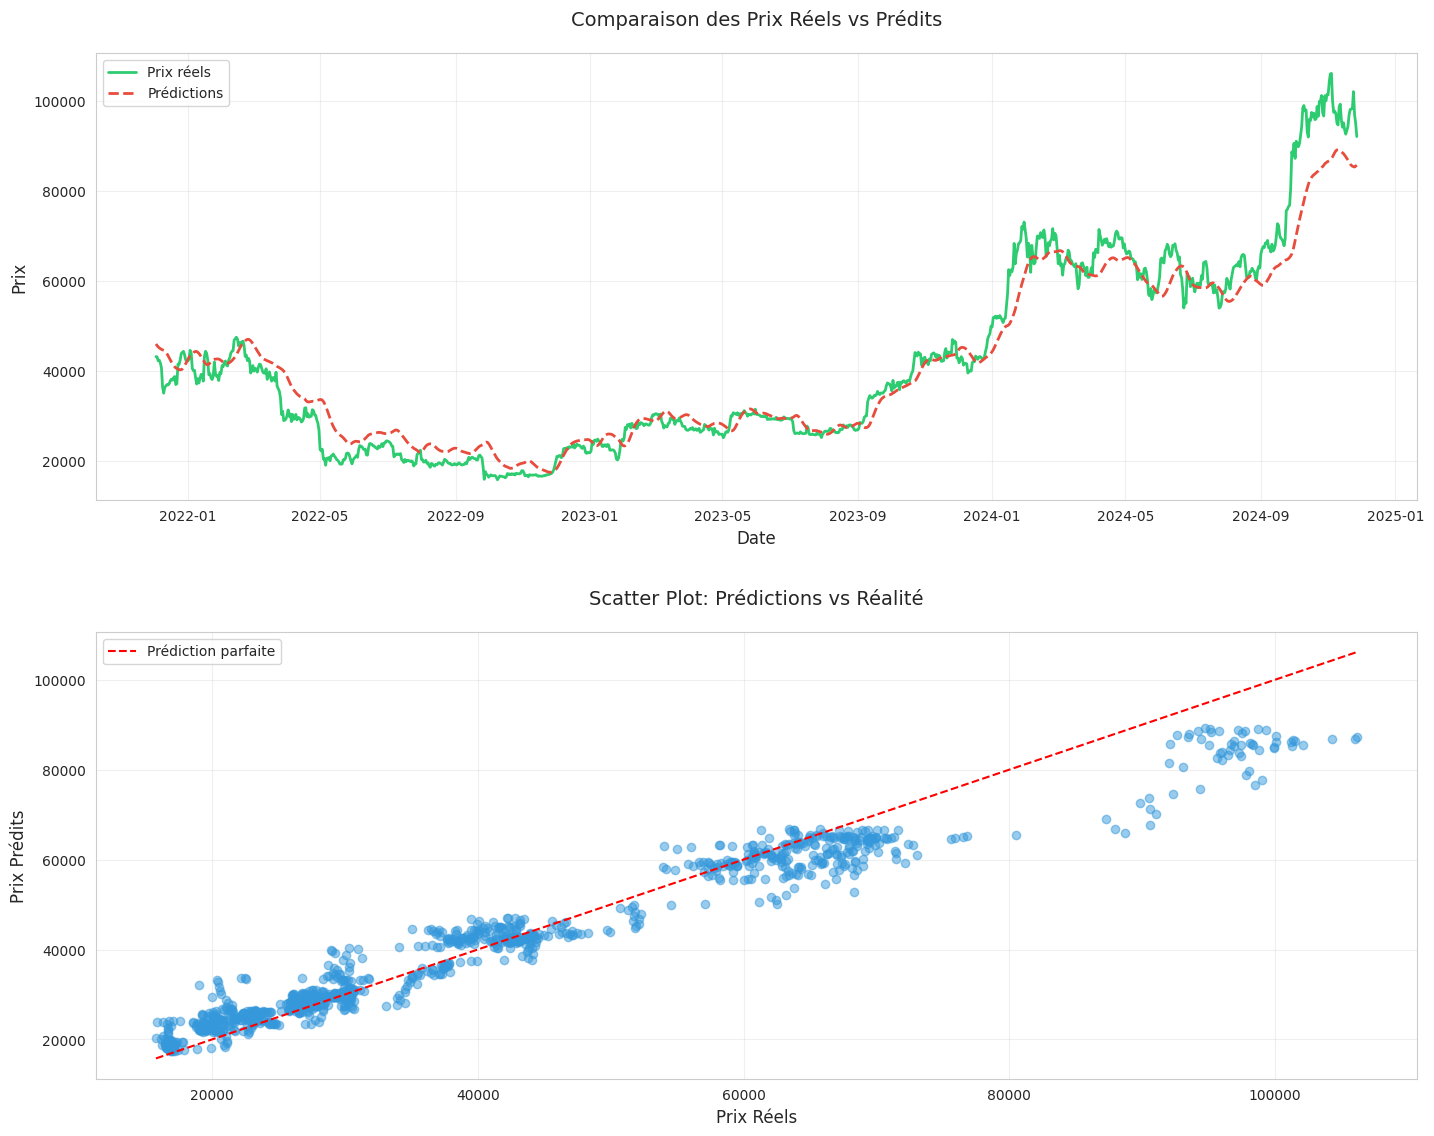

In [11]:
# Imports n√©cessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn correctement
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

def evaluate_model(model, X_test, Y_test, scaler, data, X_train, config):
    print("\n" + "="*80)
    print("√âVALUATION DU MOD√àLE".center(80))
    print("="*80)

    # Param√®tres initiaux
    training_size = len(X_train)
    window_size = config.data['window_size']
    features = config.data['features']
    target_column = features.index('Close')

    print("\n[1] G√©n√©ration des pr√©dictions")
    predictions = model.predict(X_test, verbose=0).reshape(-1, 1)

    # Pr√©paration pour l'inverse transform
    pred_full = np.zeros((predictions.shape[0], len(features)))
    pred_full[:, target_column] = predictions.flatten()

    # Inverse transform
    predicted_prices = scaler.inverse_transform(pred_full)[:, target_column]
    real_prices = scaler.inverse_transform(
        np.hstack([
            np.zeros((Y_test.shape[0], target_column)),
            Y_test.reshape(-1, 1),
            np.zeros((Y_test.shape[0], len(features) - target_column - 1))
        ])
    )[:, target_column]

    print("\n[2] Calcul des m√©triques")
    # M√©triques de base
    metrics = {
        "mae": mean_absolute_error(real_prices, predicted_prices),
        "mse": mean_squared_error(real_prices, predicted_prices),
        "rmse": np.sqrt(mean_squared_error(real_prices, predicted_prices)),
        "r2": r2_score(real_prices, predicted_prices),
        "mape": mean_absolute_percentage_error(real_prices, predicted_prices) * 100
    }

    # MASE
    naive_forecast = real_prices[:-1]
    mae_naive = mean_absolute_error(real_prices[1:], naive_forecast)
    metrics["mase"] = metrics["mae"] / mae_naive if mae_naive != 0 else None

    # Affichage des m√©triques
    print("\nM√©triques d'√©valuation:")
    for metric, value in metrics.items():
        if value is not None:
            print(f"‚Ä¢ {metric.upper()}: {value:.4f}")

    print("\n[3] G√©n√©ration des visualisations")

    # Configuration du style avec seaborn
    sns.set_style("whitegrid")

    # Cr√©ation de la figure avec les subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Dates pour l'axe x
    dates = data.index[training_size + window_size:training_size + window_size + len(predicted_prices)]

    # Premier subplot : Comparaison prix r√©els vs pr√©dictions
    ax1.plot(dates, real_prices, label='Prix r√©els', color='#2ecc71', linewidth=2)
    ax1.plot(dates, predicted_prices, label='Pr√©dictions', color='#e74c3c', linewidth=2, linestyle='--')
    ax1.set_title('Comparaison des Prix R√©els vs Pr√©dits', fontsize=14, pad=20)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Prix', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Second subplot : Scatter plot des pr√©dictions vs r√©alit√©
    ax2.scatter(real_prices, predicted_prices, alpha=0.5, color='#3498db')

    # Ligne parfaite de pr√©diction
    min_val = min(min(real_prices), min(predicted_prices))
    max_val = max(max(real_prices), max(predicted_prices))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Pr√©diction parfaite')

    ax2.set_title('Scatter Plot: Pr√©dictions vs R√©alit√©', fontsize=14, pad=20)
    ax2.set_xlabel('Prix R√©els', fontsize=12)
    ax2.set_ylabel('Prix Pr√©dits', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Ajustement de la mise en page
    plt.tight_layout(pad=3.0)

    # Log WandB optimis√©
    wandb.log({
        "model_evaluation": {
            "metrics": metrics,
            "comparison_plots": wandb.Image(plt),
            "period": {
                "start": dates[0].strftime('%Y-%m-%d'),
                "end": dates[-1].strftime('%Y-%m-%d')
            }
        }
    })

    # Afficher le plot
    plt.show()
    plt.close()

    print("\n" + "="*80)
    print("R√âSUM√â DE L'√âVALUATION".center(80))
    print("-"*80)
    print(f"‚Ä¢ P√©riode d'√©valuation: {dates[0].strftime('%Y-%m-%d')} au {dates[-1].strftime('%Y-%m-%d')}")
    print(f"‚Ä¢ Nombre de pr√©dictions: {len(predicted_prices)}")
    print(f"‚Ä¢ Erreur moyenne absolue: {metrics['mae']:.2f}")
    print(f"‚Ä¢ Erreur quadratique moyenne: {metrics['rmse']:.2f}")
    print(f"‚Ä¢ Score R¬≤: {metrics['r2']:.4f}")
    print("="*80)

    return metrics, predicted_prices, real_prices

# Appel de la fonction d'√©valuation
metrics, predicted_prices, real_prices = evaluate_model(
    model=model,
    X_test=X_test,
    Y_test=Y_test,
    scaler=scaler,
    data=data,
    X_train=X_train,
    config=wandb.config
)


                             R√âSUM√â DE L'√âVALUATION                             
--------------------------------------------------------------------------------
‚Ä¢ P√©riode d'√©valuation: 2021-12-03 au 2024-11-27
‚Ä¢ Nombre de pr√©dictions: 1091
‚Ä¢ Erreur moyenne absolue: 3545.73
‚Ä¢ Erreur quadratique moyenne: 5098.22
‚Ä¢ Score R¬≤: 0.9431

                              PR√âDICTIONS FUTURES                               

[1] Configuration de la pr√©diction
‚Ä¢ Horizon de pr√©diction: 30 jours
‚Ä¢ Fen√™tre d'observation: 90 jours

[2] G√©n√©ration des pr√©dictions

[3] Visualisation des pr√©dictions


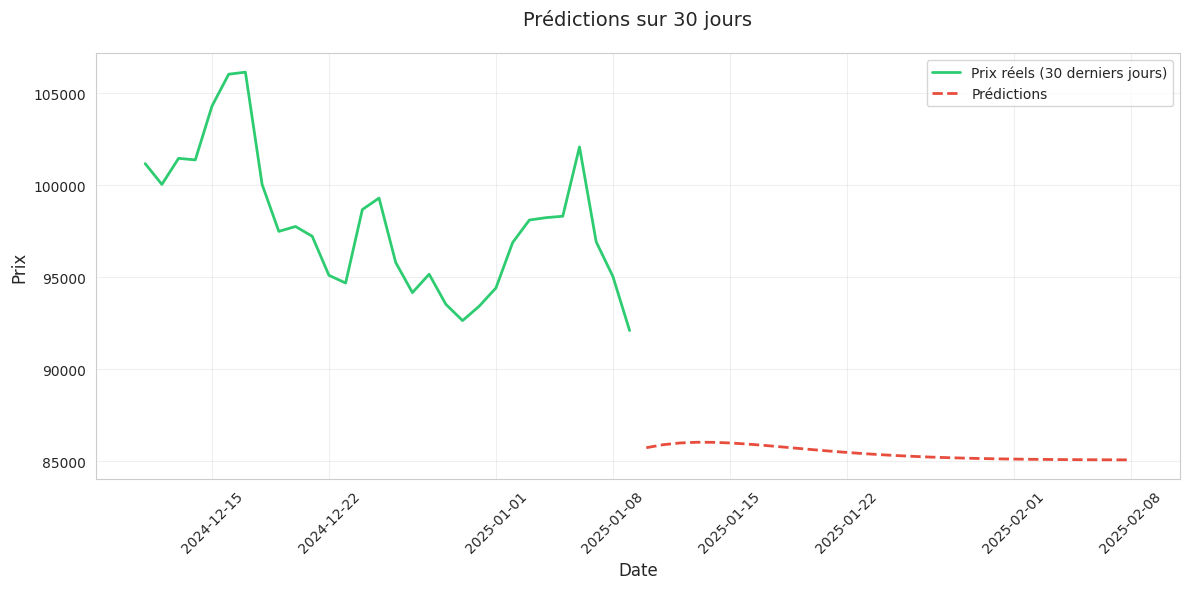


                             R√âSUM√â DES PR√âDICTIONS                             
--------------------------------------------------------------------------------
‚Ä¢ P√©riode: du 2025-01-10 au 2025-02-08
‚Ä¢ Prix initial: 85,738.39
‚Ä¢ Prix final: 85,077.87
‚Ä¢ Variation: -0.77%
‚Ä¢ Volatilit√©: 0.06%


In [12]:
def generate_future_predictions(model, X_test, X_train, data, scaler, config):
    print("\n" + "="*80)
    print("PR√âDICTIONS FUTURES".center(80))
    print("="*80)

    # Param√®tres de base
    future_days = config.data.get("future_prediction_days", 30)
    window_size = config.data['window_size']
    features = config.data['features']
    target_column_index = features.index("Close")

    print(f"\n[1] Configuration de la pr√©diction")
    print(f"‚Ä¢ Horizon de pr√©diction: {future_days} jours")
    print(f"‚Ä¢ Fen√™tre d'observation: {window_size} jours")

    print("\n[2] G√©n√©ration des pr√©dictions")
    future_predictions = []
    last_sequence = X_test[-1]

    for _ in range(future_days):
        next_pred = model.predict(last_sequence.reshape(1, window_size, X_train.shape[2]), verbose=0)
        future_predictions.append(next_pred[0, 0])
        next_time_step = last_sequence[-1].copy()
        next_time_step[target_column_index] = next_pred[0, 0]
        last_sequence = np.append(last_sequence[1:], [next_time_step], axis=0)

    # D√©normalisation
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    pred_full = np.zeros((future_predictions.shape[0], len(features)))
    pred_full[:, target_column_index] = future_predictions.flatten()
    future_prices = scaler.inverse_transform(pred_full)[:, target_column_index]

    # Dates futures
    last_date = pd.to_datetime(data.index[-1])
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                               periods=future_days, freq='D')

    print("\n[3] Visualisation des pr√©dictions")
    fig, ax = plt.subplots(figsize=(12, 6))

    # Ajout des 30 derniers jours r√©els pour contexte
    last_real_dates = data.index[-30:]
    last_real_prices = data['Close'].iloc[-30:]

    ax.plot(last_real_dates, last_real_prices,
           color='#2ecc71', label='Prix r√©els (30 derniers jours)',
           linewidth=2)
    ax.plot(future_dates, future_prices,
           color='#e74c3c', label='Pr√©dictions',
           linewidth=2, linestyle='--')

    ax.set_title(f'Pr√©dictions sur {future_days} jours', fontsize=14, pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Prix', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Calcul des statistiques cl√©s
    variation_pct = ((future_prices[-1] - future_prices[0]) / future_prices[0]) * 100
    volatility = np.std(np.diff(future_prices) / future_prices[:-1]) * 100

    # Log WandB optimis√©
    wandb.log({
        "future_forecast": {
            "plot": wandb.Image(plt),
            "metrics": {
                "price_start": float(future_prices[0]),
                "price_end": float(future_prices[-1]),
                "variation_percentage": float(variation_pct),
                "volatility_percentage": float(volatility)
            },
            "period": {
                "start": future_dates[0].strftime('%Y-%m-%d'),
                "end": future_dates[-1].strftime('%Y-%m-%d')
            }
        }
    })

    plt.show()
    plt.close()

    print("\n" + "="*80)
    print("R√âSUM√â DES PR√âDICTIONS".center(80))
    print("-"*80)
    print(f"‚Ä¢ P√©riode: du {future_dates[0].strftime('%Y-%m-%d')} au {future_dates[-1].strftime('%Y-%m-%d')}")
    print(f"‚Ä¢ Prix initial: {future_prices[0]:,.2f}")
    print(f"‚Ä¢ Prix final: {future_prices[-1]:,.2f}")
    print(f"‚Ä¢ Variation: {variation_pct:,.2f}%")
    print(f"‚Ä¢ Volatilit√©: {volatility:,.2f}%")
    print("="*80)

    return future_dates, future_prices

# Appel de la fonction
future_dates, future_prices = generate_future_predictions(
    model=model,
    X_test=X_test,
    X_train=X_train,
    data=data,
    scaler=scaler,
    config=wandb.config
)


                     VISUALISATION COMPL√àTE DES PR√âDICTIONS                     

[1] V√©rification des dimensions
‚Ä¢ Donn√©es historiques: 1091 points
‚Ä¢ Pr√©dictions futures: 30 points

Dimensions des donn√©es:
‚Ä¢ Prix r√©els: 1091
‚Ä¢ Pr√©dictions historiques: 1091
‚Ä¢ Pr√©dictions futures: 30
‚Ä¢ Dates historiques: 1091


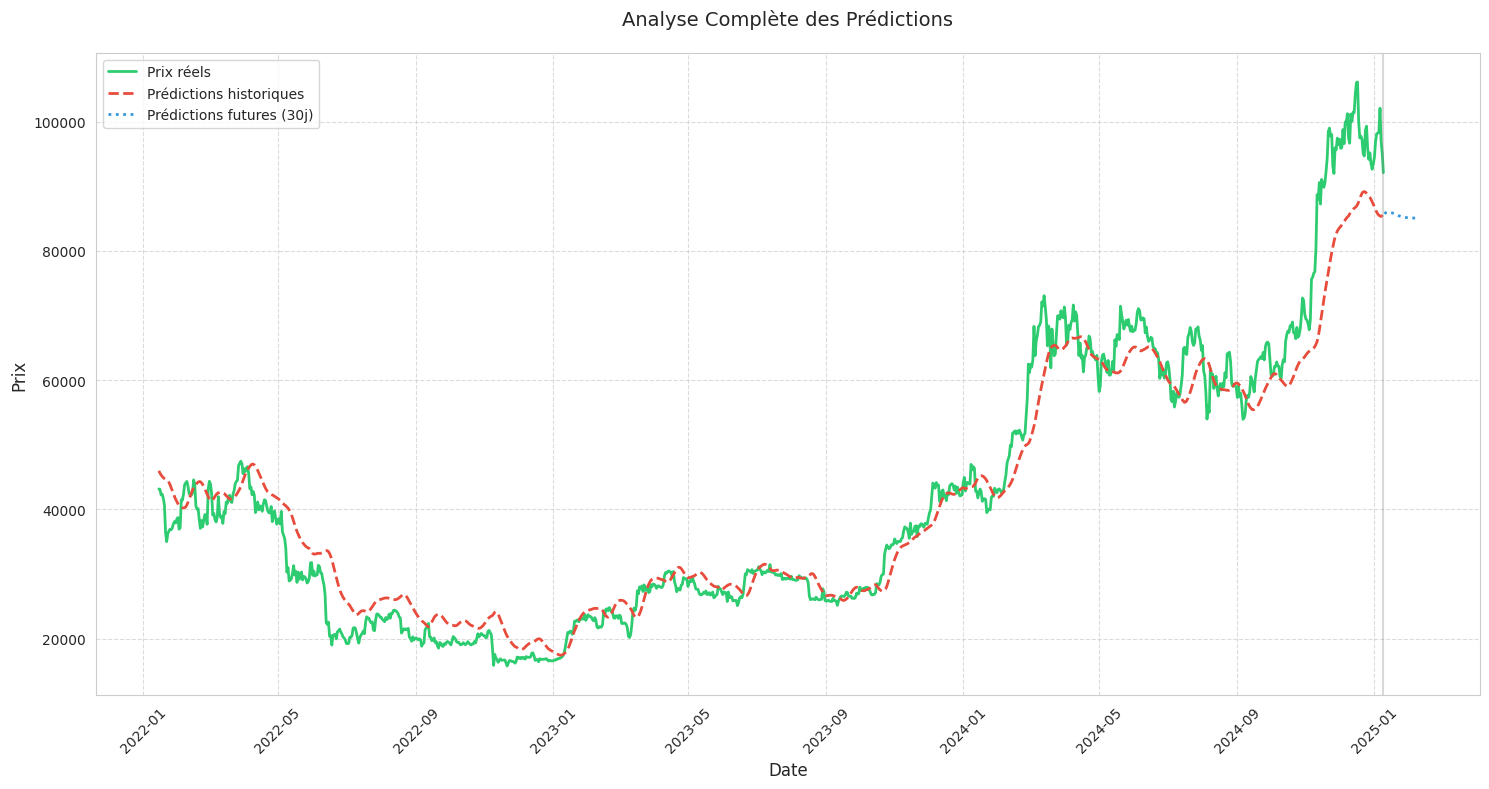

In [13]:
def visualize_combined_predictions(data, real_prices, predicted_prices, future_dates, future_prices, config):
    print("\n" + "="*80)
    print("VISUALISATION COMPL√àTE DES PR√âDICTIONS".center(80))
    print("="*80)

    # 1. Pr√©paration des dates pour les donn√©es historiques
    training_size = int(len(data) * config.data['train_test_split'])
    window_size = config.data['window_size']

    # CORRECTION: S'assurer que nous avons le bon nombre de dates
    start_idx = len(data) - len(predicted_prices)  # On commence √† partir de la fin
    historical_dates = data.index[start_idx:start_idx + len(predicted_prices)]

    print("\n[1] V√©rification des dimensions")
    print(f"‚Ä¢ Donn√©es historiques: {len(historical_dates)} points")
    print(f"‚Ä¢ Pr√©dictions futures: {len(future_dates)} points")
    print("\nDimensions des donn√©es:")
    print(f"‚Ä¢ Prix r√©els: {len(real_prices)}")
    print(f"‚Ä¢ Pr√©dictions historiques: {len(predicted_prices)}")
    print(f"‚Ä¢ Pr√©dictions futures: {len(future_prices)}")
    print(f"‚Ä¢ Dates historiques: {len(historical_dates)}")

    # V√©rification de la coh√©rence des dimensions
    assert len(historical_dates) == len(real_prices) == len(predicted_prices), \
           "Les dimensions des donn√©es historiques ne correspondent pas"

    # Cr√©ation de la visualisation
    plt.figure(figsize=(15, 8))

    # Prix r√©els et pr√©dictions historiques
    plt.plot(historical_dates, real_prices,
             label='Prix r√©els',
             color='#2ecc71',
             linewidth=2)

    plt.plot(historical_dates, predicted_prices,
             label='Pr√©dictions historiques',
             color='#e74c3c',
             linewidth=2,
             linestyle='--')

    # Pr√©dictions futures
    plt.plot(future_dates, future_prices,
             label=f'Pr√©dictions futures ({len(future_dates)}j)',
             color='#3498db',
             linewidth=2,
             linestyle=':')

    # Ligne de s√©paration
    plt.axvline(x=historical_dates[-1], color='gray', linestyle='-', alpha=0.3)

    plt.title('Analyse Compl√®te des Pr√©dictions', fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Prix', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Log WandB optimis√©
    wandb.log({
        "complete_analysis": {
            "visualization": wandb.Image(plt),
            "metrics": {
                "last_real_price": float(real_prices[-1]),
                "first_future_price": float(future_prices[0]),
                "gap_percentage": float((future_prices[0] - real_prices[-1]) / real_prices[-1] * 100)
            }
        }
    })

    plt.show()
    plt.close()

# Appel de la fonction avec les donn√©es d√©j√† pr√©par√©es
visualization = visualize_combined_predictions(
    data=data,
    real_prices=real_prices,          # De evaluate_model
    predicted_prices=predicted_prices, # De evaluate_model
    future_dates=future_dates,        # De generate_future_predictions
    future_prices=future_prices,      # De generate_future_predictions
    config=wandb.config
)

In [14]:
# Bloc : trading_signals_and_analysis_report
# R√©sum√© en 1 ligne : G√©n√®re un rapport d'analyse incluant les signaux de trading √† court et moyen terme, les tendances, les m√©triques de performance, et les pr√©dictions sur 30 jours.

def generer_rapport_analyse(real_prices, predicted_prices, future_prices, metrics, config):
    """
    G√©n√®re un rapport d√©taill√© d'analyse des pr√©dictions.
    """
    # Calculs de base
    prix_actuel = real_prices[-1]
    prix_predit_30j = future_prices[-1]
    variation_totale = ((prix_predit_30j - prix_actuel) / prix_actuel) * 100

    # Variations √† court et moyen terme
    variations = {
        "5j": ((future_prices[4] - prix_actuel) / prix_actuel) * 100,
        "20j": ((future_prices[19] - prix_actuel) / prix_actuel) * 100
    }

    # Analyse des signaux
    signaux = {
        "5j": {
            "tendance": "HAUSSI√àRE" if variations["5j"] > 0 else "BAISSI√àRE",
            "signal": "ACHETER" if variations["5j"] > 2 else "VENDRE" if variations["5j"] < -2 else "CONSERVER"
        },
        "20j": {
            "tendance": "HAUSSI√àRE" if variations["20j"] > 0 else "BAISSI√àRE",
            "signal": "ACHETER" if variations["20j"] > 5 else "VENDRE" if variations["20j"] < -5 else "CONSERVER"
        }
    }

    # Tendances CT et MT
    tendances = {
        "ct": "HAUSSI√àRE" if variations["5j"] > 1 else "BAISSI√àRE" if variations["5j"] < -1 else "NEUTRE",
        "mt": "HAUSSI√àRE" if variations["20j"] > 2 else "BAISSI√àRE" if variations["20j"] < -2 else "NEUTRE"
    }

    # Niveau de confiance
    niveau_confiance = "√âLEV√âE" if (metrics["r2"] > 0.9 and metrics["mape"] < 5) else \
                      "MOYENNE" if (metrics["r2"] > 0.7 and metrics["mape"] < 10) else "FAIBLE"

    # Log WandB optimis√© - Uniquement les m√©triques essentielles pour le sweep
    wandb.log({
        "trading_analysis": {
            "prediction_accuracy": {
                "r2": metrics["r2"],
                "mape": metrics["mape"],
                "rmse": metrics["rmse"]
            },
            "prediction_signals": {
                "variation_30j": variation_totale,
                "signal_ct": signaux['5j']['signal'],
                "signal_mt": signaux['20j']['signal'],
                "confidence": niveau_confiance
            }
        }
    })

    # G√©n√©ration du rapport texte
    rapport = f"""
======================================================================
R√âSULTATS DE L'ANALYSE
======================================================================

1. M√âTRIQUES DE PERFORMANCE
-----------------------------------
- RMSE: {metrics['rmse']:.2f} ‚Ç¨
- R¬≤: {metrics['r2']:.4f}
- MAPE: {metrics['mape']:.2f}%

2. PR√âDICTIONS
-----------------------------------
- Prix actuel: {prix_actuel:.2f} ‚Ç¨
- Prix pr√©dit dans 30 jours: {prix_predit_30j:.2f} ‚Ç¨
- Variation totale pr√©dite: {variation_totale:.2f}%

ANALYSE DE LA TENDANCE
======================================================================
Tendance √† 5 jours:
Signal: TENDANCE {signaux['5j']['tendance']} - {signaux['5j']['signal']}
Niveau Confiance: {niveau_confiance}
Variation: {variations['5j']:.2f}%
Tendance Ct: {tendances['ct']}
Tendance Mt: {tendances['mt']}

Tendance √† 20 jours:
Signal: TENDANCE {signaux['20j']['tendance']} - {signaux['20j']['signal']}
Niveau Confiance: {niveau_confiance}
Variation: {variations['20j']:.2f}%
Tendance Ct: {tendances['ct']}
Tendance Mt: {tendances['mt']}
"""

    return rapport, {
        "variations": variations,
        "signaux": signaux,
        "niveau_confiance": niveau_confiance,
        "tendances": tendances
    }

# Appel de la fonction
rapport, analyse_data = generer_rapport_analyse(
    real_prices=real_prices,
    predicted_prices=predicted_prices,  # Correction ici
    future_prices=future_prices,
    metrics=metrics,
    config=wandb.config
)

# Affichage du rapport
print(rapport)


R√âSULTATS DE L'ANALYSE

1. M√âTRIQUES DE PERFORMANCE
-----------------------------------
- RMSE: 5098.22 ‚Ç¨
- R¬≤: 0.9431
- MAPE: 9.26%

2. PR√âDICTIONS
-----------------------------------
- Prix actuel: 92103.69 ‚Ç¨
- Prix pr√©dit dans 30 jours: 85077.87 ‚Ç¨
- Variation totale pr√©dite: -7.63%

ANALYSE DE LA TENDANCE
Tendance √† 5 jours:
Signal: TENDANCE BAISSI√àRE - VENDRE
Niveau Confiance: MOYENNE
Variation: -6.59%
Tendance Ct: BAISSI√àRE
Tendance Mt: BAISSI√àRE

Tendance √† 20 jours:
Signal: TENDANCE BAISSI√àRE - VENDRE
Niveau Confiance: MOYENNE
Variation: -7.52%
Tendance Ct: BAISSI√àRE
Tendance Mt: BAISSI√àRE



In [15]:
# Bloc : market_analysis_and_recommendations
# R√©sum√© en 1 ligne : Analyse les variations des prix √† court et long terme, √©value les indicateurs techniques (RSI, volatilit√©), et g√©n√®re un rapport de recommandations de trading avec des signaux visuels et niveaux de confiance, tout en loguant les r√©sultats dans WandB.


"""
================================================================================
PHILOSOPHIE DES CONSEILS ET PARAM√àTRES
================================================================================

SIGNAUX DE TRADING :
-------------------
- FORT SIGNAL : variation > 20%
  ‚Üí Indique une forte conviction dans la direction du march√©
- SIGNAL : variation > 10%
  ‚Üí Suggestion d'action avec conviction mod√©r√©e
- MOD√âR√â : variation > 5%
  ‚Üí Opportunit√© potentielle avec prudence
- NEUTRE : entre -5% et +5%
  ‚Üí Pas de signal clair, sugg√®re l'attente

NIVEAUX DE CONFIANCE :
---------------------
- √âLEV√âE : variation > 10%
  ‚Üí Forte probabilit√© de r√©alisation
- MOYENNE : variation > 5%
  ‚Üí Probabilit√© moyenne de r√©alisation
- FAIBLE : variation ‚â§ 5%
  ‚Üí Incertitude importante

INDICATEURS TECHNIQUES :
-----------------------
RSI (Relative Strength Index) :
- Surachat : > 70
  ‚Üí Potentiel renversement √† la baisse
- Survente : < 30
  ‚Üí Potentiel renversement √† la hausse
- Neutre : entre 30 et 70
  ‚Üí Pas de signal particulier

SYMBOLES VISUELS :
-----------------
üü¢ : variations positives
üî¥ : variations n√©gatives
‚ö™ : variations neutres
‚Üó : tendance haussi√®re
‚Üò : tendance baissi√®re
‚Üí : tendance neutre
"""

import numpy as np
from datetime import datetime

import numpy as np
from datetime import datetime

def calculer_rsi(prices, period=14):
    """
    Calcule le RSI (Relative Strength Index) manuellement.
    """
    deltas = np.diff(prices)
    gains = np.where(deltas > 0, deltas, 0)
    pertes = np.where(deltas < 0, -deltas, 0)
    avg_gain = np.mean(gains[-period:])
    avg_loss = np.mean(pertes[-period:])

    if avg_loss == 0:
        return 100

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

class AnalyseMarche:
    def __init__(self, real_prices, predicted_prices, future_prices):
        self.real_prices = real_prices
        self.predicted_prices = predicted_prices
        self.future_prices = future_prices
        self.prix_actuel = real_prices[-1]
        self.variation_5j = ((future_prices[4] - self.prix_actuel) / self.prix_actuel) * 100
        self.variation_20j = ((future_prices[19] - self.prix_actuel) / self.prix_actuel) * 100
        self.rsi = calculer_rsi(real_prices)

        # Calcul de la volatilit√©
        returns = np.diff(real_prices[-21:]) / real_prices[-21:-1]
        self.volatilite = np.std(returns) * 100

        # Calcul des signaux et tendances
        self.signal_ct = self.determiner_signal(self.variation_5j)
        self.signal_lt = self.determiner_signal(self.variation_20j)
        self.tendance_ct = self.determiner_tendance(self.variation_5j)
        self.tendance_lt = self.determiner_tendance(self.variation_20j)
        self.etat_rsi = "Surachat" if self.rsi > 70 else "Survente" if self.rsi < 30 else "Neutre"

        # Calcul des forces des signaux
        self.force_signal_baissier = min(6, abs(min(0, self.variation_5j)) / 5 +
                                       abs(min(0, self.variation_20j)) / 10 +
                                       (1 if self.rsi < 30 else 0))
        self.force_signal_haussier = min(6, max(0, self.variation_5j) / 5 +
                                       max(0, self.variation_20j) / 10 +
                                       (1 if self.rsi > 70 else 0))

        # D√©termination de la recommandation finale
        if self.force_signal_haussier > self.force_signal_baissier:
            self.recommandation = "ACHAT"
            self.couleur_recommandation = "üü¢"
        elif self.force_signal_baissier > self.force_signal_haussier:
            self.recommandation = "VENTE"
            self.couleur_recommandation = "üî¥"
        else:
            self.recommandation = "NEUTRE"
            self.couleur_recommandation = "‚ö™"

    @staticmethod
    def determiner_signal(variation):
        if variation > 20:
            return "FORT SIGNAL D'ACHAT"
        elif variation > 10:
            return "SIGNAL D'ACHAT"
        elif variation > 5:
            return "ACHAT MOD√âR√â"
        elif variation < -20:
            return "FORT SIGNAL DE VENTE"
        elif variation < -10:
            return "SIGNAL DE VENTE"
        elif variation < -5:
            return "VENTE MOD√âR√âE"
        else:
            return "NEUTRE"

    @staticmethod
    def determiner_tendance(variation):
        if variation > 0:
            return "HAUSSI√àRE"
        elif variation < 0:
            return "BAISSI√àRE"
        else:
            return "NEUTRE"

    def generer_barre_force(self, force):
        return "=" * int(force * 10) + " " * (60 - int(force * 10)) + f" ({force:.1f}/6)"

    def formater_variation(self, var):
        return f"üü¢ {var:.2f}%" if var > 0 else f"üî¥ {var:.2f}%" if var < 0 else f"‚ö™ {var:.2f}%"

    def generer_rapport(self):
        rapport = f"""
================================================================================
ANALYSE DE MARCH√â - {datetime.now().strftime('%d/%m/%Y')}
================================================================================

üìä TENDANCE COURT TERME (5 JOURS)
Signal      : {self.signal_ct}
Confiance   : {"√âLEV√âE" if abs(self.variation_5j) > 10 else "MOYENNE" if abs(self.variation_5j) > 5 else "FAIBLE"}
Variation   : {self.formater_variation(self.variation_5j)}
Tendance    : {self.tendance_ct}

üìà TENDANCE LONG TERME (20 JOURS)
Signal      : {self.signal_lt}
Confiance   : {"√âLEV√âE" if abs(self.variation_20j) > 20 else "MOYENNE" if abs(self.variation_20j) > 10 else "FAIBLE"}
Variation   : {self.formater_variation(self.variation_20j)}
Tendance    : {self.tendance_lt}

üîß INDICATEURS TECHNIQUES
RSI (14 jours) : {self.rsi:.2f}
               {self.etat_rsi}
Volatilit√©    : {self.volatilite:.2f}%

================================================================================
RECOMMANDATION FINALE
================================================================================

{self.couleur_recommandation} RECOMMANDATION : {self.recommandation}

üìä Force des signaux :
Signal baissier : {self.generer_barre_force(self.force_signal_baissier)}
Signal haussier : {self.generer_barre_force(self.force_signal_haussier)}

üìã R√âSUM√â DES POINTS CL√âS
‚Ä¢ Tendance principale : {"‚Üó" if self.tendance_lt == "HAUSSI√àRE" else "‚Üò" if self.tendance_lt == "BAISSI√àRE" else "‚Üí"} {self.tendance_lt}
‚Ä¢ Variation anticip√©e (5j)  : {self.formater_variation(self.variation_5j)}
‚Ä¢ Variation anticip√©e (20j) : {self.formater_variation(self.variation_20j)}
‚Ä¢ √âtat du RSI : {self.etat_rsi}
"""
        return rapport, {
            "signal_ct": self.signal_ct,
            "signal_lt": self.signal_lt,
            "rsi": self.rsi,
            "volatilite": self.volatilite,
            "recommandation": self.recommandation
        }

# Utilisation
def analyser_marche(real_prices, predicted_prices, future_prices):
    analyse = AnalyseMarche(real_prices, predicted_prices, future_prices)
    rapport, metriques = analyse.generer_rapport()

    # Affichage du rapport
    print(rapport)

    # Enregistrement optimis√© dans W&B - uniquement les m√©triques essentielles
    wandb.log({
        "market_analysis": {
            "indicators": {
                "rsi": analyse.rsi,
                "volatility": analyse.volatilite
            },
            "predictions": {
                "variation_5d": analyse.variation_5j,
                "variation_20d": analyse.variation_20j,
                "recommendation": analyse.recommandation
            }
        }
    })

    return rapport, metriques

# Utilisation de la nouvelle fonction
rapport, metriques = analyser_marche(real_prices, predicted_prices, future_prices)


ANALYSE DE MARCH√â - 09/01/2025

üìä TENDANCE COURT TERME (5 JOURS)
Signal      : VENTE MOD√âR√âE
Confiance   : MOYENNE
Variation   : üî¥ -6.59%
Tendance    : BAISSI√àRE

üìà TENDANCE LONG TERME (20 JOURS)
Signal      : VENTE MOD√âR√âE
Confiance   : FAIBLE
Variation   : üî¥ -7.52%
Tendance    : BAISSI√àRE

üîß INDICATEURS TECHNIQUES
RSI (14 jours) : 42.48
               Neutre
Volatilit√©    : 2.30%

RECOMMANDATION FINALE

üî¥ RECOMMANDATION : VENTE

üìä Force des signaux :
Signal baissier : ====================                                         (2.1/6)
Signal haussier :                                                              (0.0/6)

üìã R√âSUM√â DES POINTS CL√âS
‚Ä¢ Tendance principale : ‚Üò BAISSI√àRE
‚Ä¢ Variation anticip√©e (5j)  : üî¥ -6.59%
‚Ä¢ Variation anticip√©e (20j) : üî¥ -7.52%
‚Ä¢ √âtat du RSI : Neutre



In [16]:
#Cloture de la session WandB
wandb.finish()

In [17]:
!pip freeze > requirements.txt